# Qauntile Regression with Random Forest

## Load the packages and functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.ensemble import RandomForestRegressor

import altair as alt
alt.renderers.enable('mimetype');
alt.data_transformers.enable('json');

import seaborn as sn

import pickle

# Load the functions
import sys
sys.path.insert(1, '../../src')
from preprocessing import*
from random_forest_functions import*
from model_evaluation import*

## Read the flow rate data, attach NARR data and split the data

In [2]:
# Read the flow rates data and select the gauge of interest
flows = read_data("../../data/station_flowrate.csv")
col = '05DF001_flow_m3s-1'
gauge = choose_gauge(flows, col)

In [3]:
# Attach NARR data to the gauge
narr_dir = "../../data/NARR_csvs/05DF001.csv"
gauge_new = add_narr(gauge, narr_dir)

In [4]:
# Choose the summer month and split the data
df_train, df_val, df_test = choose_month_and_split(gauge_new, val_size=214, test_size=214, start_month=4, end_month=10)

## Roll Forward prediction:

Please run `python RF_train_roll_forward.py` in the terminal if you want to re-train the models and re-save the predicted results in the `data/pickle` folder as pickle files. It may take long to train the model. Please note that the parameters of the models and the predictors can be changed in the [script](https://github.ubc.ca/MDS-2019-20/DSCI_591-BGC/blob/data_product/doc/Random_Forest/RF_train_roll_forward.py).

**NOTE**: You **DO NOT** need to train the model to run this notebook. The results have already been stored in the `data/pickle` folder.

### NULL model

The null model only grabs the historical flow rates on the same Julian day to form a distribution, and uses this distribution to get the quantiles wanted. The result of the null model is used to compare the result of our models.

In [5]:
# Read Null model from the saved pickle files
with open('../../data/pickle/res_null_model.pickle', 'rb') as handle:
    res_null_model = pickle.load(handle)

In [6]:
# Calculate the average quantile loss on the validation set for the Null model
null_loss = avg_quantile_loss(res_null_model, df_val, 'flow_record')
null_loss

27.663

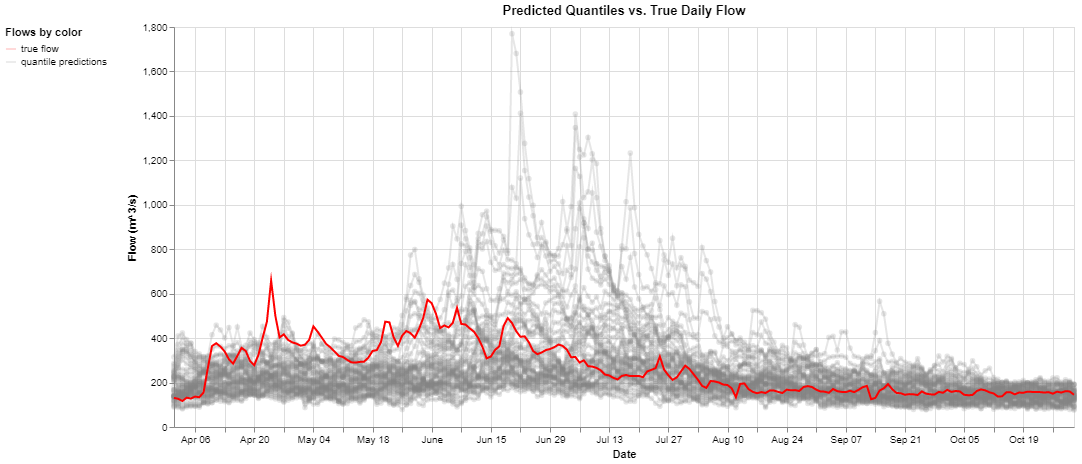

In [7]:
# Plot the predicted quantiles with true flow rates for the null model
plot_quantiles(res_null_model, df_val)

### Without NARR features

Used the three lags of flow rate as the predictors. To save the training time, only the last two-year training data is used to train to model. The parameters and predictors can be changed in the [script](https://github.ubc.ca/MDS-2019-20/DSCI_591-BGC/blob/data_product/doc/Random_Forest/RF_train_roll_forward.py).

In [8]:
# Read from the saved pickle files
with open('../../data/pickle/res_origin_flow_daily.pickle', 'rb') as handle:
    res_origin_flow = pickle.load(handle)
with open('../../data/pickle/feat_imp_daily.pickle', 'rb') as handle:
    feat_imp = pickle.load(handle)

In [9]:
# Get the average feature importance
feat_imp

array([0.91157878, 0.05983163, 0.02858958])

> As we can see from the feature importance, the model is dominated by the first lag of the flow rate

In [10]:
# Calculate the average quantile loss on the validation set
without_narr_loss = avg_quantile_loss(res_origin_flow, df_val, 'flow_record')
without_narr_loss

8.9499

> The average quantile loss has improved a lot.

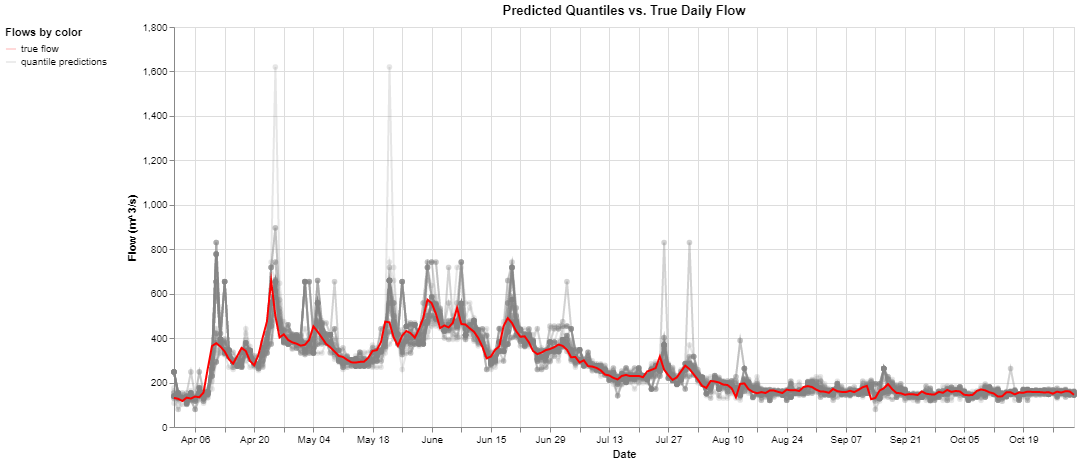

In [11]:
# Plot the predicted quantiles with true flow rates
plot_quantiles(res_origin_flow, df_val)

> The model has one-day lag in prediction and several false positives.

### With NARR features

The following chunk only performs simple EDA of part of the training set with the hope to detect the signals of the flow rate.

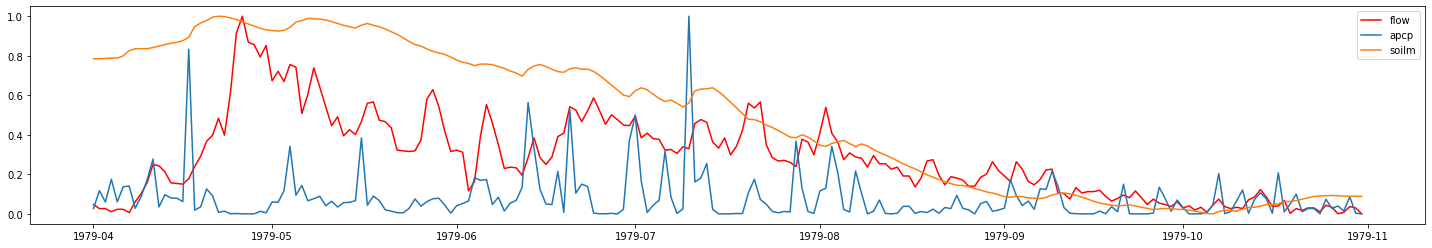

In [12]:
# Plot the normalized flow, apcp and soilm of the first year from the training set
plt.figure(figsize=(25,4))
my_df = df_train.iloc[:214,]
plt.plot((my_df['flow_record']-np.min(my_df['flow_record']))/(np.max(my_df['flow_record'])-np.min(my_df['flow_record'])), label = "flow", color = 'red')
plt.plot((my_df['apcp']-np.min(my_df['apcp']))/(np.max(my_df['apcp'])-np.min(my_df['apcp'])), label = "apcp")
plt.plot((my_df['soilm']-np.min(my_df['soilm']))/(np.max(my_df['soilm'])-np.min(my_df['soilm'])), label = "soilm")
plt.legend()
plt.show()

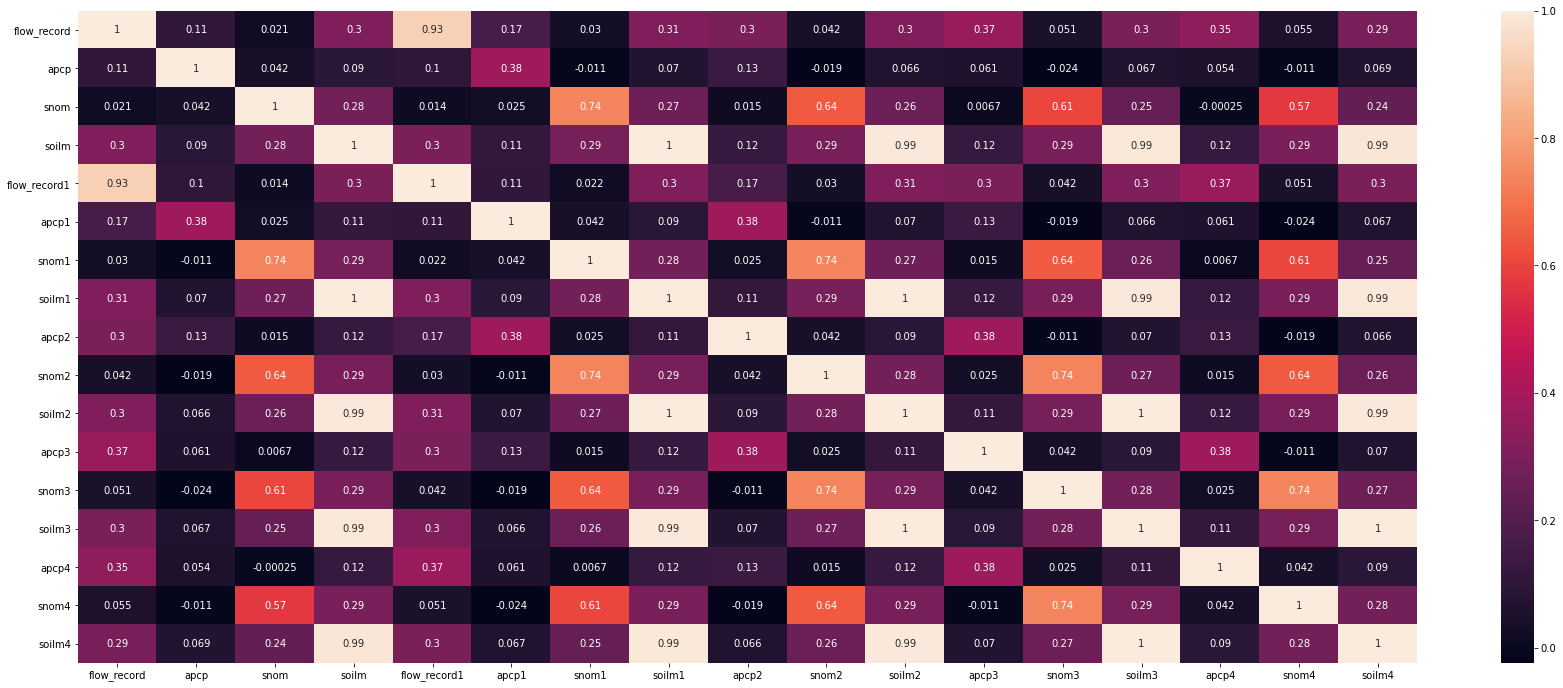

In [13]:
# Plot the correlation matrix
df_explore = df_train.copy()
df_explore = df_explore.loc[:,['flow_record', 'apcp', 'snom', 'soilm']]
df_explore = lag_df(df_explore, lag = 1, cols = ['flow_record'])
df_explore = lag_df(df_explore, lag = 4, cols = ['apcp', 'snom', 'soilm']).dropna()
corrMatrix = df_explore.corr()
plt.figure(figsize=(30,12))
sn.heatmap(corrMatrix, annot=True)
plt.show()

> Based on the above plots, 'apcp1', 'apcp2', 'apcp3', 'apcp4' and 'soilm1' are chosen from the NARR features because of the high correlation values. However, although 'soilm2', 'soilm3', and 'soilm4' also have high correlation with the flow rate, their correlations with 'soilm1' are so high that we can only use 'soilm1' to capture the signals from these four features.

The parameters and predictors can be changed in the [script](https://github.ubc.ca/MDS-2019-20/DSCI_591-BGC/blob/data_product/doc/Random_Forest/RF_train_roll_forward.py).

In [14]:
# Read from the saved pickle files
with open('../../data/pickle/narr_res_origin_flow_daily.pickle', 'rb') as handle:
    res_narr_origin_flow = pickle.load(handle)
with open('../../data/pickle/narr_feat_imp_daily.pickle', 'rb') as handle:
    feat_narr_imp = pickle.load(handle)

In [15]:
# Get the average feature importance
feat_narr_imp

array([0.73334453, 0.00808303, 0.01932382, 0.01439505, 0.01881281,
       0.20604077])

> Although the most important feature is still the first lag of the flow rate, the importance decreases compared to the model without NARR features.

In [16]:
# Calculate the average quantile loss on the validation set
with_narr_loss = avg_quantile_loss(res_narr_origin_flow, df_val, 'flow_record')
with_narr_loss

7.9646

In [17]:
1 - with_narr_loss/without_narr_loss

0.11009061553760369

> Also, the average quantile loss decreases as well. The improvement is around 11%.

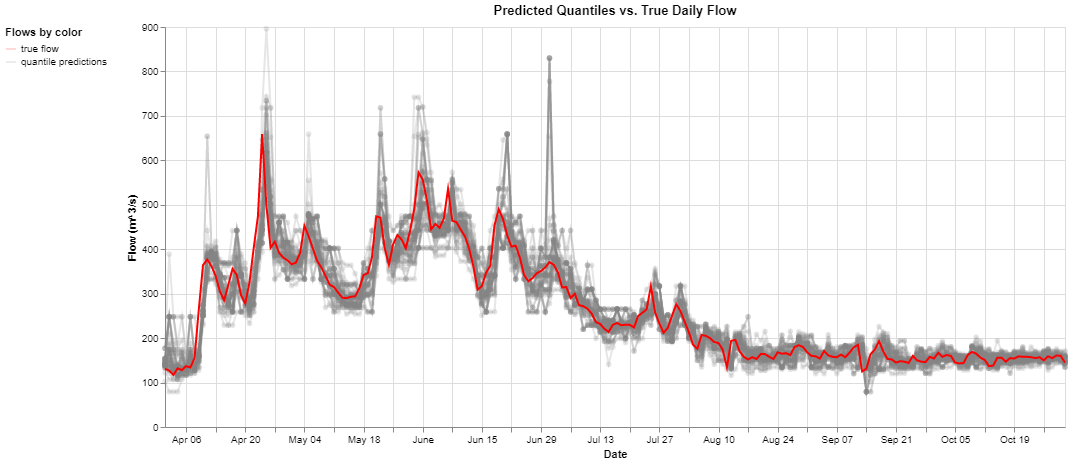

In [18]:
# Plot the predicted quantiles with true flow rates
plot_quantiles(res_narr_origin_flow, df_val)

> Although there is still one-day lag in the model, the number of false positives seems to be less than the model without NARR features. And the magnitude of the extreme values is smaller than the previous model. The maximum flow rate of the 95% quantile is less than 900 $m^3/s$ in the model with NARR features while that in the previous model is over 1600 $m^3/s$.

### Sub-Conclusion

> As we can see the average quantile loss of the random forest model is less than a third of the quantile loss of of the null model. And the average quantile loss with NARR features is less than the model without NARR features.

> However, advanced feature engineering and feature selection techniques are needed for better prediction.

## Multi-step ahead prediction

We used multiple-step ahead simulation prediction to predict 6-step ahead from the training set. It can be combined with the roll-over method on the whole validation set. However, the computational cost is so high for this combination that we only preform one prediction in this notebook.

In [19]:
# Append the training set so that we predict on a day in May
train = df_train.append(df_val.iloc[:30,:])

Please run `python RF_train_multi_step.py` in the terminal if you want to re-train the models and re-save the predicted results in the `data/pickle` folder as pickle files. Please note that the parameters of the models and the predictors can be changed in the [script](https://github.ubc.ca/MDS-2019-20/DSCI_591-BGC/blob/data_product/doc/Random_Forest/RF_train_multi_step.py).

**NOTE**: You **DO NOT** need to train the model to run this notebook. The results have already been stored in the `data/pickle` folder.

### Without NARR data

We used the same predictors as the previous model, the three lags of flow rate. This can be changed in the [script](https://github.ubc.ca/MDS-2019-20/DSCI_591-BGC/blob/data_product/doc/Random_Forest/RF_train_multi_step.py) if better predictors are found.

In [20]:
# Read the result from the saved pickle file
with open('../../data/pickle/res_six_ahead.pickle', 'rb') as handle:
    res_six_ahead = pickle.load(handle)

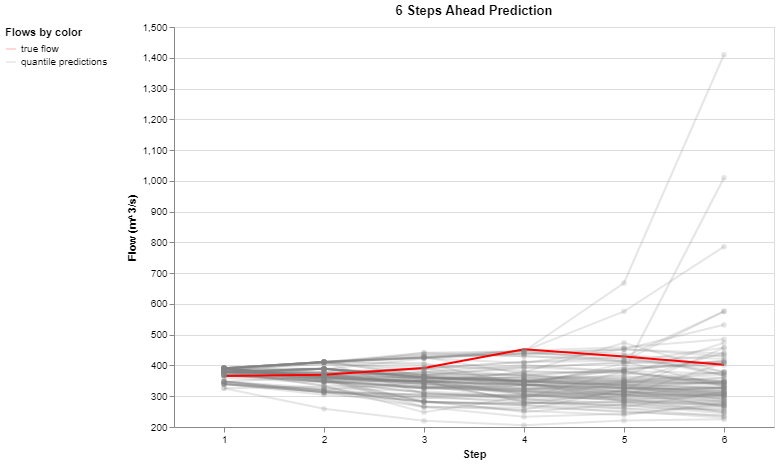

In [21]:
plot_multiple_step_prediction(train, df_val.iloc[30:,], res_six_ahead, hourly=False)

In [22]:
# Calculate the quantile loss on these 6 steps
avg_loss_multiple_step(res_six_ahead, df_val.iloc[30:,], label='flow_record')

117.7918

### With NARR data

Here we only used the one lag of the flow rate and different lags of the soil moisture as the predictors for the six models we trained. Please note that the predictors for each model are different. These predictors can be changed in the [script](https://github.ubc.ca/MDS-2019-20/DSCI_591-BGC/blob/data_product/doc/Random_Forest/RF_train_multi_step.py) if better features are found.

In [23]:
# Read the result from the saved pickle file
with open('../../data/pickle/res_six_ahead_narr.pickle', 'rb') as handle:
    res_six_ahead_narr = pickle.load(handle)

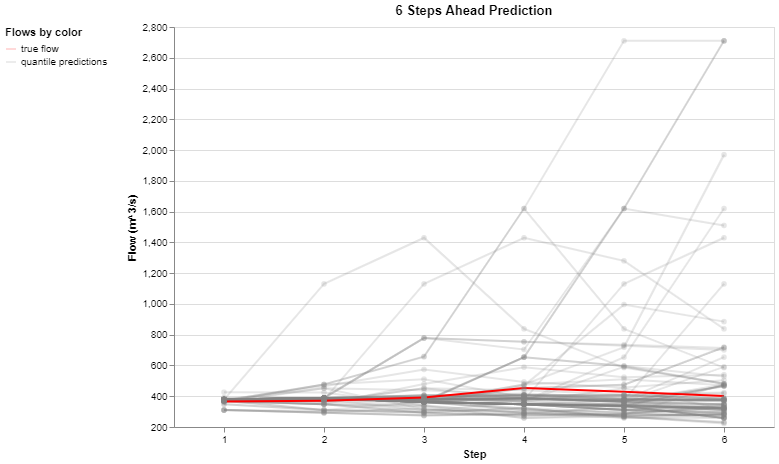

In [24]:
plot_multiple_step_prediction(train, df_val.iloc[30:,], res_six_ahead_narr, hourly=False)

In [25]:
# Calculate the quantile loss on these 6 steps
avg_loss_multiple_step(res_six_ahead_narr, df_val.iloc[30:,], label='flow_record')

92.4139

### Sub-Conclusion

As we can see from the above results, by adding the NARR feature, the quantile loss on the six steps decreased a bit. However, more advanced feature engineering and feature selection techniques are needed to get better predictors to capture the signals of high flow rate. Also, because of the limitation of the computational power, we didn't perform this multiple-step ahead prediction on the whole validation set. We believe with more powerful and parallel computation, this simulation prediction can be applied to the whole validation set to detect better predictors.

Also, during our experiments, we found that the size of the training set is an important hyperparameter for this model. It is not necessary that the larger the size is, the lower quantile loss we will get. One guess for the reason is that the features affect the flow rate may change from year to year. In some situation, if larger training set is used, some useful features in recent years might become noises because they may be useless in the previous years. This hyperparameter may also need to be fine tuned to get better results.